# Project Description


In [1]:
#The aim of this project is to create a recomendation model for the movielens dataset. The dataset is provided by
#GroupLens research lab at the University of Minnesota.

## Import packages

In [106]:
#import basic packages 
import  pandas as pd
import numpy as np

#import graphic tools
import matplotlib.pyplot as plt
import seaborn as sns

#import surprise 
from surprise import Reader, Dataset
from surprise import CoClustering
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split, cross_validate
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline

# Get the Data

In [3]:
#import the data as panda dataframes
links = pd.read_csv('/Users/arun/Desktop/Flatiron/Projects/Phase4_Project/ml-latest-small/links.csv')
ratings = pd.read_csv('/Users/arun/Desktop/Flatiron/Projects/Phase4_Project/ml-latest-small/ratings.csv')
movies = pd.read_csv('/Users/arun/Desktop/Flatiron/Projects/Phase4_Project/ml-latest-small/movies.csv')
tags = pd.read_csv('/Users/arun/Desktop/Flatiron/Projects/Phase4_Project/ml-latest-small/tags.csv')

# EDA

In [4]:
#Links are codes for IMDB and TMDB sites. This wont be helpful unless I have to go to IMDB or TMDB for more data 
#on these movies.
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [5]:
#getting some basic information for ratings. Ratings does not include the name of the movie.
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
#looking for null values
print(f"Number of null values for ratings: \n{ratings.isna().sum()}")

Number of null values for ratings: 
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [7]:
#timestamp will need to be removed or changed to datetime. We can see that users rated multiple movies.
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
#going to drop timestamp since I don't need it.
ratings.drop('timestamp', axis = 1, inplace = True)

In [9]:
#Start with the UserId column.
#610 people are responsible for rating the movies in this dataset.
print(f"Number of users who rated movies: {len(ratings['userId'].unique())}")

Number of users who rated movies: 610


In [10]:
#grouping users and rating 
users = ratings.groupby(['userId'])['rating'].count().sort_values(ascending=False)

#Majority of ratings coming from a few users. Will need to be reguarlized to be useful for the model.
print(users)

userId
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
442      20
569      20
320      20
576      20
53       20
Name: rating, Length: 610, dtype: int64


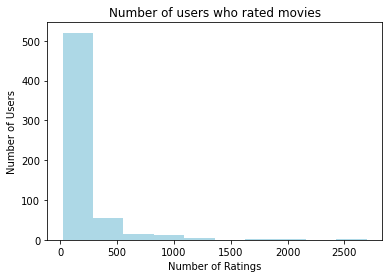

In [11]:
#The majority of movies rated by less then 25 people
plt.subplots(figsize = (6, 4))
plt.hist(users, color = 'lightblue')
plt.title('Number of users who rated movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show();

In [12]:
#There are over 10K ratings but only 9724 unique movie values. 
print(f"Number of movies: {len(ratings['movieId'].unique())}")

#taking a look at the average rating in the dataset.
print(f"The average rating for movies in this dataset is: {ratings['rating'].mean()}")

#how many bins are the ratings split into
print(f"The ratings are split into: {len(ratings['rating'].unique())} categories")

#There are not many movies will lower scores. Perhaps people tend not to rate movies they do not like.
print(ratings['rating'].value_counts(normalize=True))

Number of movies: 9724
The average rating for movies in this dataset is: 3.501556983616962
The ratings are split into: 10 categories
4.0    0.265957
3.0    0.198808
5.0    0.131015
3.5    0.130271
4.5    0.084801
2.0    0.074884
2.5    0.055040
1.0    0.027877
1.5    0.017762
0.5    0.013586
Name: rating, dtype: float64


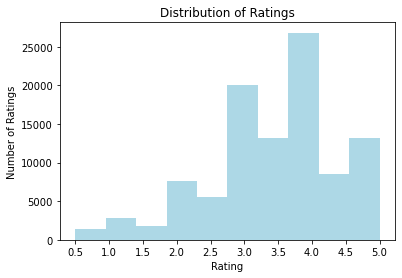

In [13]:
#graph a distribition of ratings using a histogram. 10 bins because the ratings are in 10 categories.
#The distribution of ratings is highly skewed, this could be a problem when training the model.

plt.subplots(figsize = (6, 4))
plt.hist(ratings['rating'], bins = 10, color = 'lightblue')
plt.xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show();

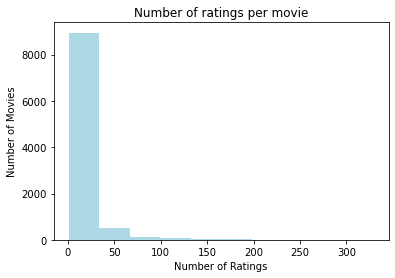

In [14]:
#taking a look at how many ratings a movie recieved
num_ratings = ratings.groupby(['movieId'])['rating'].count()

#plotting number of ratings per movie. The majority of movies recieved less then 25 ratings.
plt.subplots(figsize = (6, 4))
plt.hist(num_ratings, color = 'lightblue')
plt.title('Number of ratings per movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show();

In [15]:
#Taking a look at the movies data
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [16]:
#Movie title inludes the year, which should ideally be its own category. 
#Also, movies are in multiple genres, could skew the genre count. 
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [17]:
#extract the year from title and set it as its own column
movies['release_year'] = movies['title'].apply(lambda x: x.strip()[-5:-1])

In [18]:
#Turning release_year to a data time format
movies['release_year'] = pd.to_datetime(movies['release_year'], errors='coerce')

In [19]:
#look for nulls
print(movies.isna().sum())

#Unique movie titles and Ids should match.
print(f"Number of unique movie titles:  {len(movies.title.unique())}")

#looking for unique movie Ids 
print(f"Number of unique movie Ids:  {len(movies.movieId.unique())}")


movieId          0
title            0
genres           0
release_year    12
dtype: int64
Number of unique movie titles:  9737
Number of unique movie Ids:  9742


In [20]:
#There are movies with multiple Ids
duplicates = movies[movies['title'].duplicated(keep = False)]
print(duplicates)

      movieId                                   title  \
650       838                             Emma (1996)   
2141     2851                         Saturn 3 (1980)   
4169     6003  Confessions of a Dangerous Mind (2002)   
5601    26958                             Emma (1996)   
5854    32600                             Eros (2004)   
5931    34048                War of the Worlds (2005)   
6932    64997                War of the Worlds (2005)   
9106   144606  Confessions of a Dangerous Mind (2002)   
9135   147002                             Eros (2004)   
9468   168358                         Saturn 3 (1980)   

                                   genres release_year  
650                  Comedy|Drama|Romance   1996-01-01  
2141            Adventure|Sci-Fi|Thriller   1980-01-01  
4169          Comedy|Crime|Drama|Thriller   2002-01-01  
5601                              Romance   1996-01-01  
5854                                Drama   2004-01-01  
5931     Action|Adventure|Sci-

In [23]:
#Dropping rows that have less information because they are redundant 
drop_rows = [4169, 5601, 5854, 6932, 9468]
movies.drop(drop_rows, axis = 0, inplace = True)

#checking again for duplicates
duplicates = movies[movies['title'].duplicated(keep = False)]
print(duplicates)


Empty DataFrame
Columns: [movieId, title, genres, release_year]
Index: []


In [24]:
#There are 951 unique genre combinations. 
print(f"Unique number of movie genres: {len(movies['genres'].unique())}")

#There are genre combinations with just one movie listed in them. 
movies['genres'].value_counts()

Unique number of movie genres: 951


Drama                                                  1052
Comedy                                                  946
Comedy|Drama                                            435
Comedy|Romance                                          363
Drama|Romance                                           349
                                                       ... 
Action|Crime|Horror|Mystery|Thriller                      1
Adventure|Animation|Children|Comedy|Musical|Romance       1
Action|Adventure|Animation|Comedy|Crime|Mystery           1
Children|Comedy|Fantasy|Sci-Fi                            1
Action|Animation|Comedy|Fantasy                           1
Name: genres, Length: 951, dtype: int64

<AxesSubplot: xlabel='title', ylabel='genres'>

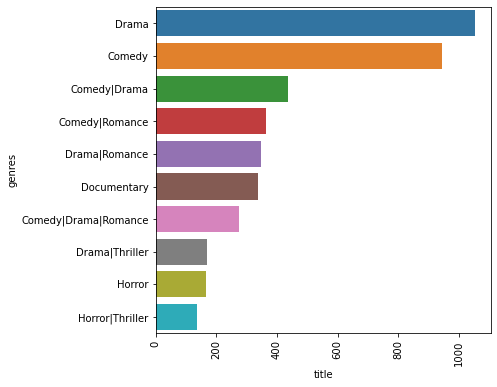

In [86]:
#want to take a look at the top 10 genres by value counts 
top_genres = pd.DataFrame(movies.groupby('genres')['title'].count())

#sorting to get the highest values on top
top_genres = top_genres.sort_values('title', ascending=False)[:10]

#reseting the index
top_genres.reset_index(inplace=True)

# we can see the top 5 genre with ratings are a Drama, Comedy and some combination of the 2.
plt.figure(figsize=(6, 6))
plt.xticks(rotation=90)
sns.barplot(data = top_genres, x = 'title', y = 'genres', orient='h')

In [26]:
#Now to look at tags
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [27]:
#going to drop timestamp since I don't need it.
tags.drop('timestamp', axis = 1, inplace = True)

In [28]:
#number of unique tags
print(f"Number of unique tags: {len(tags['tag'].unique())}")

#number of movies with tags
print(f"Number of movies with tags: {len(tags['movieId'].unique())}")

#lets look at how many people provided tags
print(f"Number of users who provided tags: {len(tags['userId'].unique())}")

Number of unique tags: 1589
Number of movies with tags: 1572
Number of users who provided tags: 58


In [29]:
#there are over 3000 movies in this dataframe but only 1589 unique tags, so we should have some repeats.
#Let's see what are the most populat tags.

#tags have upper and lower case. Better to make them all lower first 
tags['tag'] = tags['tag'].str.lower()

tags['tag'].value_counts()

in netflix queue     131
atmospheric           41
funny                 24
superhero             24
thought-provoking     24
                    ... 
ichabod crane          1
scifi                  1
dust bowl              1
new society            1
immigration            1
Name: tag, Length: 1475, dtype: int64

In [30]:
#will have to write a loop to count tags and get their names
count_tags = {}
for tag in tags['tag']:
    count_tags[tag] = count_tags.get(tag, 0) + 1

#sort the dictionary, just taking the top 16 values.
sorted_tag = dict(sorted(count_tags.items(), key=lambda x:x[1], reverse = True)[:16])

#get the top 16 tags and their counts
for x in list(sorted_tag)[0:16]:
    print ("{}, {}".format(x,  sorted_tag[x]))

in netflix queue, 131
atmospheric, 41
funny, 24
superhero, 24
surreal, 24
thought-provoking, 24
sci-fi, 23
disney, 23
quirky, 22
religion, 22
dark comedy, 21
suspense, 21
psychology, 21
twist ending, 20
visually appealing, 20
comedy, 19


In [31]:
#removing "in netflix queue"
del sorted_tag['in netflix queue']

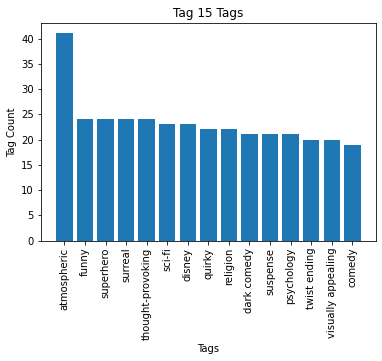

In [32]:
#plot the key and items of the dictionary. shows us the most popular tags
names = list(sorted_tag.keys())
values = list(sorted_tag.values())


plt.bar(range(len(sorted_tag)), values, tick_label=names)
plt.xticks(rotation=90)
plt.xlabel('Tags')
plt.ylabel('Tag Count')
plt.title('Tag 15 Tags')
plt.show()

In [33]:
#need to merge movies and ratings for the next EDA step
movies_ratings = pd.merge(movies,ratings, on = 'movieId', how = 'left')

print(movies_ratings.shape)

(100834, 6)


In [34]:
#The 3 datasets have been joined below, this is EDA for the relationship between ratings and years.
#I want to see the average number of ratings per year.

avg_rating = pd.DataFrame(movies_ratings.groupby('release_year')['rating'].mean())

In [35]:
#reset the index so release year is its own column and just look at the last 50 entries.
avg_rating.reset_index(inplace=True)

avg_rating = avg_rating[50:]

#get the lowest value in ratings, this will help reduce noise for plotting.
print(avg_rating['rating'].min())

3.335292812777285


In [36]:
avg_rating['year'] = avg_rating['release_year'].dt.strftime('%Y')

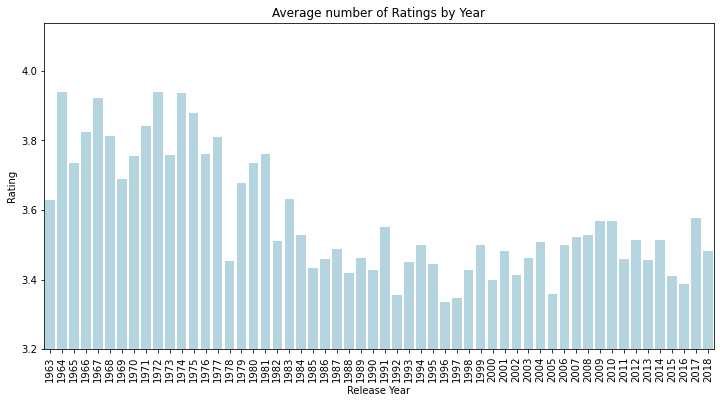

In [37]:
#there is a lot of data for release year, maybe just look at the movies for the last 50 years.
#since the smallest value in ratings is 3.33, going to start Y axis at 3.2 to reduce noise.
#Looks there is a downward trend in users rating movies.

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data = avg_rating, x = 'year', y = 'rating', color = 'lightblue')
plt.ylim(3.2)
plt.title('Average number of Ratings by Year')
ax.set_ylabel('Rating')
ax.set_xlabel('Release Year')
plt.xticks(rotation=90)
plt.show()

# Join the Data

In [38]:
#Look at the shape of all 3 datasets

print(f" The shape of movies is: {movies.shape}")
print(f" The shape of ratings is: {ratings.shape}")
print(f" The shape of tags is: {tags.shape}")

 The shape of movies is: (9737, 4)
 The shape of ratings is: (100836, 3)
 The shape of tags is: (3683, 3)


In [39]:
#All 3 datasets have movieId column, going to set that as the index.

movies.set_index('movieId', drop=True, inplace=True)
ratings.set_index('movieId', drop=True, inplace=True)
tags.set_index('movieId', drop=True, inplace=True)

In [40]:
#start by merging the movies and ratings datasets
movies_ratings = pd.merge(movies,ratings, on = 'movieId', how = 'left')

print(movies_ratings.shape)

(100834, 5)


In [41]:
#look for all null values
nan_values = movies_ratings.isna().sum()

#there are 35 rows with null values and we have over 100k. should be fine to drop.
len(nan_values)

5

In [42]:
#going to drop all null and nat values
movies_ratings = movies_ratings.dropna()

#no more null values, clean dataset
movies_ratings.isna().sum()

title           0
genres          0
release_year    0
userId          0
rating          0
dtype: int64

In [43]:
#reset the index so that movieId is its own column
movies_ratings.reset_index(inplace=True)

In [44]:
movies_ratings

,movieId,title,genres,release_year,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995-01-01,1.0,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995-01-01,5.0,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995-01-01,7.0,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995-01-01,15.0,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995-01-01,17.0,4.5
...,...,...,...,...,...,...
100794,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017-01-01,184.0,4.0
100795,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017-01-01,184.0,3.5
100796,193585,Flint (2017),Drama,2017-01-01,184.0,3.5
100797,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018-01-01,184.0,3.5


In [48]:
#keeping title and the columns needed for modeling
df = movies_ratings[['movieId','userId','rating']]

In [49]:
df

,movieId,userId,rating
0,1,1.0,4.0
1,1,5.0,4.0
2,1,7.0,4.5
3,1,15.0,2.5
4,1,17.0,4.5
...,...,...,...
100794,193581,184.0,4.0
100795,193583,184.0,3.5
100796,193585,184.0,3.5
100797,193587,184.0,3.5


# Modeling 

In [50]:
#load the data set into reader to use surprise 
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df,reader)

In [51]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  9707 

Number of items:  610


# SVD

In [52]:
#Perform a gridsearch with SVD
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)

print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8740744718645006, 'mae': 0.67249640773216}
{'rmse': {'n_factors': 100, 'reg_all': 0.05}, 'mae': {'n_factors': 100, 'reg_all': 0.05}}


# KNN Basic

In [53]:
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.96748845, 0.96677912, 0.97059467, 0.97441798, 0.96907071]))
('test_mae', array([0.75349872, 0.74884604, 0.75410466, 0.75732908, 0.75286555]))
('fit_time', (29.37694501876831, 37.65001606941223, 34.216678857803345, 36.177207946777344, 8.034549951553345))
('test_time', (32.77606511116028, 26.911401987075806, 29.378684997558594, 27.76911425590515, 5.872281074523926))
-----------------------
0.9696701829740052


# KNN Baseline

In [84]:
# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)

for i in cv_knn_baseline.items():
    print(i)
print('-----------------------')
np.mean(cv_knn_baseline['test_rmse'])

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
('test_rmse', array([0.87738938, 0.88496284, 0.88885517, 0.88396664, 0.88789498]))
('test_mae', array([0.67348252, 0.68240873, 0.68403914, 0.68028217, 0.68203458]))
('fit_time', (6.654615879058838, 6.931823015213013, 6.81413197517395, 7.644606113433838, 6.826820135116577))
('test_time', (6.999417304992676, 7.0642759799957275, 7.759622097015381, 8.05874490737915, 6.955322027206421))


0.8846138026181389

# Recomendations

In [87]:
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list  

In [88]:
user_rating = movie_rater(movies_ratings, 4, 'Comedy')

       movieId                         title                        genres  \
11800      420  Beverly Hills Cop III (1994)  Action|Comedy|Crime|Thriller   

      release_year  userId  rating  
11800   1994-01-01   136.0     3.0  
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
       movieId         title  \
61462     4306  Shrek (2001)   

                                                  genres release_year  userId  \
61462  Adventure|Animation|Children|Comedy|Fantasy|Ro...   2001-01-01   488.0   

       rating  
61462     5.0  
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
       movieId                      title        genres release_year  userId  \
94642    95939  Angels' Share, The (2012)  Comedy|Drama   2012-01-01   483.0   

       rating  
94642     4.0  
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
       movieId                    title              genres release_year  \
803

# Make Predictions 

In [72]:
#going to use the ratings from the user given above to make recomendations 

In [73]:
#KNN Model, since it gave the highest RMSE score

In [89]:
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)
knn_basic.fit(new_data.build_full_trainset())

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [90]:
# make predictions for the user
list_of_movies = []
for m_id in df['movieId'].unique():
    list_of_movies.append((m_id,knn_basic.predict(1000,m_id)[3]))

In [91]:
# order the predictions from highest to lowest rated
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

#make the values unique
ranked_movies = set(ranked_movies)


In [103]:
# return the top n recommendations using the 
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            title = title.unique()
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies_ratings,5)

Recommendation #  1 :  ['Unforgettable Summer, An (Un été inoubliable) (1994)'] 

Recommendation #  2 :  ['Winged Migration (Peuple migrateur, Le) (2001)'] 

Recommendation #  3 :  ['Curse of the Golden Flower (Man cheng jin dai huang jin jia) (2006)'] 

Recommendation #  4 :  ['Talladega Nights: The Ballad of Ricky Bobby (2006)'] 

Recommendation #  5 :  ['Fright Night Part II (1988)'] 

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
